Now that we have the database where image directory, image_name and feature vector of the image is saved. We can query for the most similar image for an input image from the database. 

When a user submits a query image, we use pre-trained model to extract features from the query image. Calculate the cosine similarity between the query image's feature vector and the feature vectors stored in your database using NumPy. This will give us a list of similarity scores. Then we Sort the similarity scores in descending order to find the most similar images. Retrieve the metadata associated with the images that have the highest similarity scores. This metadata will help us identify and present the most similar images to the user.

In [1]:
import sqlite3
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

2023-08-28 07:35:51.592050: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the input image
input_image_path = 'img/img/MEN/Sweatshirts_Hoodies/id_00000319/01_2_side.jpg'
input_img = image.load_img(input_image_path, target_size=(224, 224))
input_img_array = image.img_to_array(input_img)
input_img_array = np.expand_dims(input_img_array, axis=0)
input_img_array = preprocess_input(input_img_array)

In [3]:
# Extract features from the input image using the same ResNet50 model
model = vgg16.VGG16(weights='imagenet', include_top=False, pooling='avg')
input_img_features = model.predict(input_img_array)

2023-08-28 07:35:54.732821: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


1/1 [==============================] - 0s 242ms/step


In [4]:
# Connect to the SQLite database
conn = sqlite3.connect('image_features_database.db')
cursor = conn.cursor()

# Retrieve directory, image filenames and features from the database
cursor.execute('SELECT directory, filename, features FROM image_features')
rows = cursor.fetchall()

In [5]:
similarities = []

for row in rows:
    directory, filename, db_img_features_bytes = row
    db_img_features = np.frombuffer(db_img_features_bytes, dtype=np.float32)
    db_img_features = db_img_features.reshape(1, -1)  # Reshape to match input shape
    similarity = cosine_similarity(input_img_features, db_img_features)
    similarities.append((directory,filename, similarity))

# Sort images by similarity (closest first)
similarities.sort(key=lambda x: x[2], reverse=True)

# Print the most similar image
most_sim_img_dir, most_sim_img_name , similarity = similarities[1][0:3]
print("Most similar image:", os.path.join(most_sim_img_dir,most_sim_img_name))
print("Similarity is", similarity)

# You can also print or analyze other similar images if needed
conn.close()

Most similar image: img/img/MEN/Sweatshirts_Hoodies/id_00000319/01_4_full.jpg
Similarity is [[0.839357]]


In [6]:
out_img = image.load_img(os.path.join(most_sim_img_dir,most_sim_img_name))

Below shown images are 83.935699 percent similar


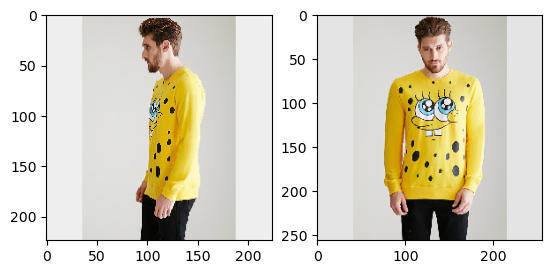

In [7]:
print("Below shown images are %f percent similar"%(similarity*100) )
plt.figure()
plt.subplot(1,2,1)
plt.imshow(input_img)
plt.subplot(1,2,2)
plt.imshow(out_img)

Given the large size of our database, it's seggested to explore methods such as Approximate Nearest Neighbors (ANN) to enhance the efficiency of our search operations. The conventional approach of computing similarity matrices individually for each entry in the database, followed by sorting and retrieving the most similar images in response to a given image, could prove computationally intensive. To address this, we can turn to specialized libraries like Faiss or Annoy, which offer solutions for accelerating this process. These libraries leverage techniques like indexing and approximate search to significantly reduce the computational burden while maintaining a satisfactory level of result accuracy.